In [2]:
import time #used for benchmarking
from torch import *
from dlc_practical_prologue import *
from torch import nn
from torch import optim
from torch.nn import functional as F

In [3]:
import matplotlib 
from matplotlib import pyplot as plt

# Dataset generation

In [6]:
def generate_digit_sets(train_input, train_classes, test_input, test_classes):
    num_samples = train_input.size(0) * 2
    digit_train_input = train_input.view(-1, 1, 14, 14)
    digit_test_input = test_input.view(-1, 1, 14, 14)
    
    digit_train_classes = train_classes.view(-1)
    digit_test_classes = test_classes.view(-1)
    digit_train_target = Tensor(num_samples, 10).zero_()
    digit_test_target = Tensor(num_samples, 10).zero_()
    for i in range(10):
        digit_train_target[:,i] = (digit_train_classes == i) * 1.0
        digit_test_target[:,i] = (digit_test_classes == i) * 1.0
    
    return digit_train_input, digit_train_target, digit_test_input, digit_test_target

In [7]:
num_samples = 1000
num_digits_samples = num_samples * 2

train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(num_samples)
digit_train_input, digit_train_target, digit_test_input, digit_test_target = generate_digit_sets(train_input, train_classes, test_input, test_classes)
aux_train_target = digit_train_target.view(-1,20)

In [8]:
print(digit_train_target.shape)

torch.Size([2000, 10])


In [9]:
mu, std = train_input.mean(), train_input.std();
train_input.sub_(mu).div_(std);
test_input.sub_(mu).div_(std);

# Useful model methods (train, predict, evaluate performances)

In [10]:
def total_number_of_params(model):
    """
    Return the total number of trainable parameters of a model

    Args:
        model (torch.nn): pytorch neural net model

    Returns:
        int: number of trainable parameters of a model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
def prediction_from_digit(digit_output):
    """
    Return the predicted class of a comparaison between 2 digits.
    Requires a tensor whose main dimension is divisible by 2!

    Args:
        digit_output (torch.Tensor): output of a digit regression of size (2*N, 10)

    Returns:
        torch.Tensor of size(N, 1): class of the comparaison of 2 consecutive digits
            a row is set at 1 if the first digit is smaller than the second, 0 otherwise
    """ 
    _, predicted_digit_classes = digit_output.max(1)
    predicted_digit_pair = predicted_digit_classes.view(-1, 2)
    predicted_classes = (predicted_digit_pair[:,0] - predicted_digit_pair[:,1] <= 0) * 1
    return predicted_classes


def prediction_from_comparaison(comp_output):
    """
    Return the predicted class of a comparaison from a regression.

    Args:
        comp_output (torch.Tensor): output of a digit classifier of size (N, 1)

    Returns:
        torch.Tensor of size(N, 1): a row is set at 1 if the regression output 
            is bigger than 0.5, 0 otherwise
    """
    return (comp_output >= 0.5) * 1.0
   
    
def compute_nb_errors(predicted, target):
    """
    Compute the number of errors between a prediction and a target
    
    Args:
        predicted (torch.Tensor of size (N, D)): result from a model predictions
        target (torch.Tensor of size (N, D)): target classes
        
    Returns:
        float: error rate
        int: total number of errors
        int: number of samples
    """
    #print(predicted.shape)
    #print(target.shape)
    error = (predicted != target.view(predicted.shape)) * 1.0
    
    return error.mean().item(), int(error.sum().item()), error.shape[0]

# Models
### Purely linear (= no context)

In [12]:
def train_model(model, train_input, train_target, aux_train_target=None, mini_batch_size=100, wd = 0, lr=0.1, iterations=25, aux_loss_weight=0.5, is_digit=False, comp_target = None):
    """
    Train a pytorch model with provided input and output.
    Can also add an auxiliary target to avoid vanishing gradients
    and get better accuracy.

    Args:
        model (torch.nn): pytorch neural net model
        train_input (torch.Tensor of size (N, D)): training set
        train_target (torch.Tensor of size (N, num_classes)): target set
        aux_train_target (torch.Tensor): auxiliary target, None by default
        mini_batch_size (int): batch size for data loading/training
        lr (float): learning rate
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    training_loss = torch.empty((iterations,1))
    training_error = torch.empty((iterations,1))
    
    for e in range(iterations):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            optimizer.zero_grad()
            if aux_train_target is None:
                output = model(train_input.narrow(0, b, mini_batch_size))
                target = train_target.narrow(0, b, mini_batch_size)
                loss = criterion(output, target)
                
                
            # In the case we use also an auxiliary loss
            # (currently works for only one additional auxiliary loss)
            else:
                output, output_aux = model(train_input.narrow(0, b, mini_batch_size))
                target = train_target.narrow(0, b, mini_batch_size)
                aux_size_factor = int(output_aux.shape[0] / output.shape[0])
                target_aux = aux_train_target.narrow(0, aux_size_factor * b, aux_size_factor * mini_batch_size)
                # Here, heavily penalizing auxiliary loss can result to better classification
                #loss = (1-aux_loss_weight)*criterion(output, target) + aux_loss_weight * criterion(output_aux, target_aux)
                loss = criterion(output, target) + aux_loss_weight * criterion(output_aux, target_aux)
            
            if is_digit is False:
                predicted = prediction_from_comparaison(output)
                error, _, _ = compute_nb_errors(predicted,target)
            else:
                predicted = prediction_from_digit(output)
                error, _, _ = compute_nb_errors(predicted,comp_target.narrow(0,int(b/2),int(mini_batch_size/2)))
            #print(error)
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            optimizer.step()    
       
            
        training_loss[e] = sum_loss
        training_error[e] = error
        print(e, sum_loss, end = '\r')

    return training_loss, training_error

In [13]:
def get_linear_net():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(392,150), nn.ReLU(),
        nn.Linear(150,100), nn.ReLU(),
        nn.Linear(100,1)
    )

linear_net = get_linear_net()
print("#parameters =", total_number_of_params(linear_net))
train_model(linear_net, train_input, train_target.float().view(-1,1), mini_batch_size=100, lr=5e-4)

train_predicted = prediction_from_comparaison(linear_net(train_input))
print("Training error rate: {:.3f} ({}/{})".format(*compute_nb_errors(train_predicted, train_target)))
test_predicted = prediction_from_comparaison(linear_net(test_input))
print("Test error rate: {:.3f} ({}/{})".format(*compute_nb_errors(test_predicted, test_target)))

#parameters = 74151
Training error rate: 0.000 (0/1000)
Test error rate: 0.219 (219/1000)


### CNN: Using digits as training features

In [14]:
def get_dig_net():
    return nn.Sequential(
        nn.Conv2d(1,  32, 3), nn.ReLU(), nn.MaxPool2d(2, stride = 2),
        nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, stride = 2), nn.Flatten(),
        nn.Linear(256, 100), nn.ReLU(),
        nn.Linear(100, 200), nn.ReLU(),
        nn.Linear(200, 100), nn.ReLU(),
        nn.Linear(100,  10)
        #nn.Conv2d(1, 32, 4) ,nn.ReLU(), nn.MaxPool2d(2, stride = 2),
        #nn.Conv2d(32, 64, 4) ,nn.ReLU(),nn.MaxPool2d(2, stride = 2),
        #nn.Flatten(),
        #nn.Linear(64, 128), nn.ReLU(),
        #nn.Linear(128, 32), nn.ReLU(),
        #nn.Linear(32, 10)
    )

dig_net = get_dig_net()
print("#parameters =", total_number_of_params(dig_net))
training_loss, training_error = train_model(dig_net, digit_train_input, digit_train_target, mini_batch_size=100, lr=5e-3, is_digit = True, comp_target=train_target)

train_predicted = prediction_from_digit(dig_net(digit_train_input))
print("Training error rate: {:.3f} ({}/{})".format(*compute_nb_errors(train_predicted, train_target)))
test_predicted = prediction_from_digit(dig_net(digit_test_input))

print(test_predicted.shape)
print(test_target.shape)
print("Test error rate: {:.3f} ({}/{})".format(*compute_nb_errors(test_predicted, test_target)))

#parameters = 85826
Training error rate: 0.000 (0/1000)
torch.Size([1000])
torch.Size([1000])
Test error rate: 0.043 (43/1000)


### CNN: Simple

In [15]:
def get_comp_net_normal():
    return nn.Sequential(
        nn.Conv2d(2, 16, 2) ,nn.ReLU(),
        nn.Conv2d(16, 32, 2) ,nn.ReLU(),
        nn.Conv2d(32, 32, 2) ,nn.ReLU(), nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(800, 75), nn.ReLU(),
        nn.Linear(75, 75), nn.ReLU(),
        nn.Linear(75, 1)
    )

comp_net_normal = get_comp_net_normal()
print("#parameters =", total_number_of_params(comp_net_normal))
train_model(comp_net_normal, train_input, train_target.float().view(-1,1), mini_batch_size=100, lr=5e-4)

train_predicted = prediction_from_comparaison(comp_net_normal(train_input))
print("Training error rate: {:.3f} ({}/{})".format(*compute_nb_errors(train_predicted, train_target)))
test_predicted = prediction_from_comparaison(comp_net_normal(test_input))
print("Test error rate: {:.3f} ({}/{})".format(*compute_nb_errors(test_predicted, test_target)))

#parameters = 72203
Training error rate: 0.044 (44/1000)
Test error rate: 0.197 (197/1000)


### CNN: Shared weights (sequential)

In [16]:
def get_comp_net_shared(): 
    weight_shared_layer1 = nn.Sequential(nn.Linear(75, 75), nn.ReLU())
    weight_shared_layer2 = nn.Sequential(nn.Linear(75, 75), nn.ReLU())
    return nn.Sequential(
        nn.Conv2d(2, 16, 2) ,nn.ReLU(),
        nn.Conv2d(16, 32, 2) ,nn.ReLU(),
        nn.Conv2d(32, 32, 2) ,nn.ReLU(), nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(800, 75), nn.ReLU(),
        weight_shared_layer1,
        weight_shared_layer1,
        weight_shared_layer1,
        nn.Linear(75, 1)
    )

comp_net_shared = get_comp_net_shared()
print("#parameters =", total_number_of_params(comp_net_shared))
training_error = train_model(comp_net_shared, train_input, train_target.float().view(-1,1), mini_batch_size=100, lr=5e-4)

train_predicted = prediction_from_comparaison(comp_net_shared(train_input))
print("Training error rate: {:.3f} ({}/{})".format(*compute_nb_errors(train_predicted, train_target)))
test_predicted = prediction_from_comparaison(comp_net_shared(test_input))
print("Test error rate: {:.3f} ({}/{})".format(*compute_nb_errors(test_predicted, test_target)))

#parameters = 72203
Training error rate: 0.099 (99/1000)
Test error rate: 0.200 (200/1000)


In [17]:
print(train_input.shape, train_target.float().view(-1,1).shape)

torch.Size([1000, 2, 14, 14]) torch.Size([1000, 1])


### CNN: Auxiliary loss (on digit classes)  

In [18]:
class AuxLossCnn(nn.Module):
    def __init__(self):
        super(AuxLossCnn, self).__init__()
        self.digit_model = nn.Sequential(
            nn.Conv2d(1, 16, 4) ,nn.ReLU(),
            nn.Conv2d(16, 32, 4) ,nn.ReLU(),
            nn.Conv2d(32, 32, 4) ,nn.ReLU(),
            nn.Flatten(),
            nn.Linear(800, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.comparaison_model = nn.Sequential(
            nn.ReLU(),
            nn.Linear(20, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(), 
            nn.Linear(50, 50), nn.ReLU(),  
            nn.Linear(50,  1)
        )
        
    def forward(self, x):
        x = x.view(-1, 2, 1, x.shape[2], x.shape[3])
        dig1, dig2 = self.digit_model(x[:,0]), self.digit_model(x[:,1])
        x = torch.cat([dig1, dig2], axis=1)
        x_aux = x.view(-1, 10)
        x = self.comparaison_model(x)
        return x, x_aux
    
def get_aux_loss_cnn(): return AuxLossCnn()

comp_net_aux_loss = AuxLossCnn()
print("#parameters =", total_number_of_params(comp_net_aux_loss))
training_loss, training_error = train_model(comp_net_aux_loss, train_input, train_target.float().view(-1,1), aux_train_target=digit_train_target, mini_batch_size=100, lr=5e-4, aux_loss_weight=40)

train_predicted = prediction_from_comparaison(comp_net_aux_loss(train_input)[0])
print("Training error rate: {:.3f} ({}/{})".format(*compute_nb_errors(train_predicted, train_target)))
test_predicted = prediction_from_comparaison(comp_net_aux_loss(test_input)[0])
print("Test error rate: {:.3f} ({}/{})".format(*compute_nb_errors(test_predicted, test_target)))

#parameters = 74223
Training error rate: 0.033 (33/1000)
Test error rate: 0.057 (57/1000)


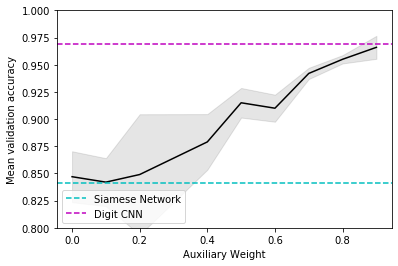

In [19]:
import pylab
import numpy as np
#weight = np.array([0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 400, 500, 600, 700, 800, 1000])
#mean = np.array([ 1-0.157, 1-0.14, 1-0.101, 1-0.056000, 1-0.044, 1-0.036, 1-0.029, 1-0.037, 1-0.037, 1-0.038, 1-0.033, 1-0.034, 1-0.04, 1-0.03,1-0.035, 1-0.04 ])
#sigma = np.array([0.019967, 0.012649, 0.008869,  0.013466,0.014236, 0.003266,0.005033, 0.008869,0.011489,0.023664, 0.011015 , 0.007659, 0.017588, 0.009522, 0.011944, 0.013466  ])

weight = np.array([0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
mean = np.array([ 1-0.153, 1-0.158, 1-0.151, 1-0.121000, 1-0.085, 1-0.09, 1-0.058, 1-0.045, 1-0.034])
sigma = np.array([0.023409, 0.022030, 0.055462,  0.025586,0.013614, 0.012437, 0.005164, 0.003830,0.010583 ])
plt.plot(weight, mean, 'k')
pylab.ylim(0.8,1)
plt.fill_between(weight, mean-sigma, mean+sigma, alpha=0.1, facecolor = 'k', edgecolor = 'k')

#plt.plot(0, 0.841, marker = "x", markersize = 10, label = 'Siamese Network')
#plt.plot(0, 0.969, marker = "x", markersize = 10, label = 'Digit CNN')
plt.axhline(y=0.841, color='c', linestyle='--', label = 'Siamese Network')
plt.axhline(y=0.969, color='m', linestyle='--', label = 'Digit CNN')

plt.legend()
#plt.gca().set_xscale('log')
plt.xlabel('Auxiliary Weight')
plt.ylabel('Mean validation accuracy')
plt.savefig("weight.png")


### CNN : Siamese Network (parallel weight sharing)

In [20]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.digit_model = nn.Sequential(
            nn.Conv2d(1, 16, 4) ,nn.ReLU(),
            nn.Conv2d(16, 32, 4) ,nn.ReLU(),
            nn.Conv2d(32, 32, 4) ,nn.ReLU(),
            nn.Flatten(),
            nn.Linear(800, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.comparaison_model = nn.Sequential(
            nn.ReLU(),
            nn.Linear(20, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(), 
            nn.Linear(50, 50), nn.ReLU(),  
            nn.Linear(50,  1)
        )
        
    def forward(self, x):
        x = x.view(-1, 2, 1, x.shape[2], x.shape[3])
        dig1, dig2 = self.digit_model(x[:,0]), self.digit_model(x[:,1])
        x = torch.cat([dig1, dig2], axis=1)
        x_aux = x.view(-1, 10)
        x = self.comparaison_model(x)
        return x
    
def get_siamese_net(): return SiameseNetwork()

siamese_net = get_siamese_net()
print("#parameters =", total_number_of_params(siamese_net))
training_loss1, training_error1 = train_model(siamese_net, train_input, train_target.float().view(-1,1), mini_batch_size=50, lr=5e-4)

train_predicted = prediction_from_comparaison(siamese_net(train_input))
print("Training error rate: {:.3f} ({}/{})".format(*compute_nb_errors(train_predicted, train_target)))
test_predicted = prediction_from_comparaison(siamese_net(test_input))
print("Test error rate: {:.3f} ({}/{})".format(*compute_nb_errors(test_predicted, test_target)))

#parameters = 74223
Training error rate: 0.033 (33/1000)
Test error rate: 0.182 (182/1000)


In [21]:
def evaluate_model(model_generator, lr = 5e-4, is_digit_model=False, use_aux_target=False, rounds=25, aux_loss_weight=None):
    errors = torch.empty((rounds,1))
    training_losses = torch.empty((rounds,25))
    for k in range(rounds):
        model = model_generator()
        
        num_samples = 1000
        comp_train_input, comp_train_target, comp_train_classes, comp_test_input, comp_test_target, comp_test_classes = generate_pair_sets(num_samples)
        digit_train_input, digit_train_target, digit_test_input, digit_test_target = generate_digit_sets(comp_train_input, comp_train_classes, comp_test_input, comp_test_classes)
        
        mu, std = comp_train_input.mean(), comp_train_input.std();
        comp_train_input.sub_(mu).div_(std);
        comp_test_input.sub_(mu).div_(std);
        
        aux_train_target = digit_train_target if use_aux_target else None       
        model_train_input = digit_train_input if is_digit_model else comp_train_input
        model_train_target = digit_train_target if is_digit_model else comp_train_target.float().view(-1,1)
        model_test_input = digit_test_input if is_digit_model else comp_test_input
        
        _, training_error = train_model(model, model_train_input, model_train_target, mini_batch_size=100, lr=lr, aux_train_target=aux_train_target, aux_loss_weight=aux_loss_weight, is_digit=is_digit_model, comp_target = comp_train_target.float().view(-1,1))
        
        output = model(model_test_input)
        if use_aux_target:
            output = output[0]
        
        predicted = prediction_from_digit(output) if is_digit_model else prediction_from_comparaison(output)        
        
        error,_,_ = compute_nb_errors(predicted, comp_test_target)
        errors[k] = error
        #print(training_loss.t().shape)
        training_losses[k] = training_error.t()
    return (torch.mean(errors).item(), torch.std(errors).item(), torch.mean(training_losses, axis = 0))

In [22]:
def split_dataset(train_target, k, fold, train_input):
    n = train_input.size(0)
    size = int(np.floor(n/fold))
    val_input_set = train_input.narrow(0, k*size, size )
    val_target_set = train_target.narrow(0,k*size,size)

    if k == 0:
        train_input_set = train_input.narrow(0, size, n - size)
        train_target_set = train_target.narrow(0, size, n - size)

    elif size*k == n - size:
        train_input_set = train_input.narrow(0, 0, n - size )
        train_target_set = train_target.narrow(0, 0, n - size )
    else:
        train_input_set = torch.cat((train_input.narrow(0, 0, k*size),
                                        train_input.narrow(0, (k+1)*size, n -(k+1)*size )), 0)
        train_target_set = torch.cat((train_target.narrow(0, 0, k*size),
                                        train_target.narrow(0, (k+1)*size, n -(k+1)*size )), 0)
    
    return val_input_set, val_target_set, train_input_set, train_target_set

In [23]:
models_dict = {
    "Digit CNN": {"gen": get_dig_net, "aux":False, "is_digit":True, "lr" : 1e-3},
    "Simple CNN": {"gen": get_comp_net_normal, "aux": False, "is_digit":False, "lr" : 1e-3},
    "Weight sharing CNN": {"gen": get_comp_net_shared, "aux": False, "is_digit":False, "lr" : 1e-3},
    "Siamese CNN": {"gen": get_siamese_net, "aux": False, "is_digit":False, "lr" : 1e-3},
    "Auxiliary loss CNN (weight=0.5)": {"gen": get_aux_loss_cnn, "aux": True, "is_digit":False, "weight":0.5, "lr" : 1e-3},
    "Auxiliary loss CNN (weight=2)": {"gen": get_aux_loss_cnn, "aux": True, "is_digit":False, "weight":2, "lr" : 1e-3},
    "Auxiliary loss CNN (weight=10)": {"gen": get_aux_loss_cnn, "aux": True, "is_digit":False, "weight":10, "lr" : 5e-3},
    "Auxiliary loss CNN (weight=40)": {"gen": get_aux_loss_cnn, "aux": True, "is_digit":False, "weight":40, "lr" : 1e-3}
}

Digit CNN with 10 rounds in 15.892221440900002:
#parameters = 85826
    mean accuracy: 0.977
    stdv accuracy: 0.004551

Simple CNN with 10 rounds in 10.707219896000003:
#parameters = 72203
    mean accuracy: 0.795
    stdv accuracy: 0.014183

Weight sharing CNN with 10 rounds in 10.893369039500005:
#parameters = 72203
    mean accuracy: 0.789
    stdv accuracy: 0.025555

Siamese CNN with 10 rounds in 16.7440100595:
#parameters = 74223
    mean accuracy: 0.844
    stdv accuracy: 0.013113

Auxiliary loss CNN (weight=0.5) with 10 rounds in 16.692456814999993:
#parameters = 74223
    mean accuracy: 0.880
    stdv accuracy: 0.012746

Auxiliary loss CNN (weight=2) with 10 rounds in 16.2377729456:
#parameters = 74223
    mean accuracy: 0.941
    stdv accuracy: 0.011766

Auxiliary loss CNN (weight=10) with 10 rounds in 16.2598180274:
#parameters = 74223
    mean accuracy: 0.968
    stdv accuracy: 0.012237

Auxiliary loss CNN (weight=40) with 10 rounds in 17.628495591800014:
#parameters = 742

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


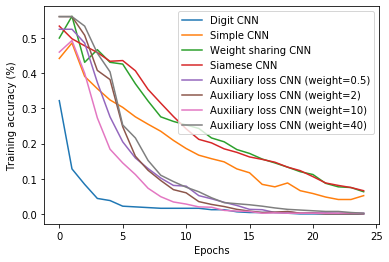

In [24]:
num_rounds = 10
plt.figure()
for key in models_dict.keys():
    gen = models_dict[key]["gen"]
    aux_target = models_dict[key]["aux"]
    digit_model = models_dict[key]["is_digit"]
    aux_loss_weight = models_dict[key]["weight"] if aux_target else None
    lr = models_dict[key]["lr"]
    
    
    start = time.perf_counter()
    mean, std, loss = evaluate_model(gen, lr = lr, is_digit_model=digit_model, use_aux_target=aux_target, rounds=num_rounds, aux_loss_weight=aux_loss_weight)
    mean = 1 - mean
    avg_time = (time.perf_counter() - start) / num_rounds
    plt.plot(loss, label = "{}".format(key))
    print("{} with {} rounds in {}:".format(key, num_rounds, avg_time))
    print("#parameters =", total_number_of_params(gen()))
    print("   training mean accuracy: {:.3f}".format(1-loss[-1].item()))
    print("    mean accuracy: {:.3f}".format(mean))
    print("    stdv accuracy: {:.6f}".format(std))
    print()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training accuracy (%)')
plt.savefig("training.eps")

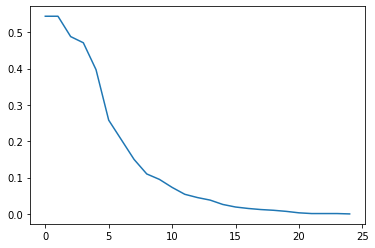

In [156]:
#%matplotlib inline
import pylab
plt.figure()
plt.plot(loss)
plt.savefig("training.png")

# Cross-validation

In [29]:
for key in models_dict.keys():
    gen = models_dict[key]["gen"]
    aux_target = models_dict[key]["aux"]
    digit_model = models_dict[key]["is_digit"]
    aux_loss_weight = models_dict[key]["weight"] if aux_target else None
    lr = models_dict[key]["lr"]
    print(key)
    cross_validation(gen, train_input, train_target, digit_train_input, digit_train_target, is_digit_model=digit_model, use_aux_target=aux_target, aux_loss_weight= aux_loss_weight, lr = lr, fold = 10)


Digit CNN
0.00015980861503630877
Lr : 0.000100 Mean Validation error : 0.037000 Std Validation error: 0.020575
0.000554971934179775426
Lr : 0.000500 Mean Validation error : 0.024000 Std Validation error: 0.013499
0.001009680815637693745
Lr : 0.001000 Mean Validation error : 0.022000 Std Validation error: 0.019889
0.0051341376957716420324
Lr : 0.005000 Mean Validation error : 0.044000 Std Validation error: 0.016465
0.01.24377611279487653
Lr : 0.010000 Mean Validation error : 0.113000 Std Validation error: 0.126759
Simple CNN
0.0001232747837901115
Lr : 0.000100 Mean Validation error : 0.246000 Std Validation error: 0.038930
0.00055568887833505877
Lr : 0.000500 Mean Validation error : 0.228000 Std Validation error: 0.032592
0.001112617588834837083
Lr : 0.001000 Mean Validation error : 0.220000 Std Validation error: 0.035590
0.005026782101369462907
Lr : 0.005000 Mean Validation error : 0.231000 Std Validation error: 0.035103
0.01.87321516126394275
Lr : 0.010000 Mean Validation error : 0.28

In [118]:
print(train_input.shape, train_target.shape, digit_train_input.shape, digit_train_target.shape)

torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([2000, 1, 14, 14]) torch.Size([2000, 10])
